# scGen - Perturbation response prediction

This tutorial reproduces https://scgen.readthedocs.io/en/stable/tutorials/scgen_perturbation_prediction.html with our custom Jax implementation.

In [1]:
import pertpy as pt
import scanpy as sc
from scvi import REGISTRY_KEYS

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

### Loading Train Data

In [2]:
train = pt.dt.kang_2018()

In [3]:
train.raw = train.copy()
sc.pp.normalize_total(train)

Let's remove stimulated CD4 T cells from the training set, as we want to generalize our stimulated condition to them.

In [4]:
train_new = train[~((train.obs["cell_type"] == "CD4 T cells") & (train.obs["label"] == "stim"))]
train_new = train_new.copy()

### Preprocessing Data

In [5]:
pt.tl.SCGEN.setup_anndata(train_new, batch_key="label", labels_key="cell_type")

## Creating the model¶

In [6]:
scgen_model = pt.tl.SCGEN(train_new)

I0000 00:00:1700241529.542823       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


## Training the Model

In [7]:
scgen_model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
    accelerator="cpu",
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|██████████| 100/100 [1:15:03<00:00, 44.92s/it, v_num=1, train_loss_step=6.41e+3, train_loss_epoch=3.06e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [1:15:03<00:00, 45.04s/it, v_num=1, train_loss_step=6.41e+3, train_loss_epoch=3.06e+4]


## Saving the model

In [8]:
scgen_model.save("../saved_models/model_perturbation_prediction.pt", overwrite=True)

### Latent Space

We will now obtain the latent representation that was calculated by our model and visualize it using UMAP.

In [9]:
latent_X = scgen_model.get_latent_representation()
latent_adata = sc.AnnData(X=latent_X, obs=train_new.obs.copy())

         Falling back to preprocessing with `sc.pp.pca` and default params.


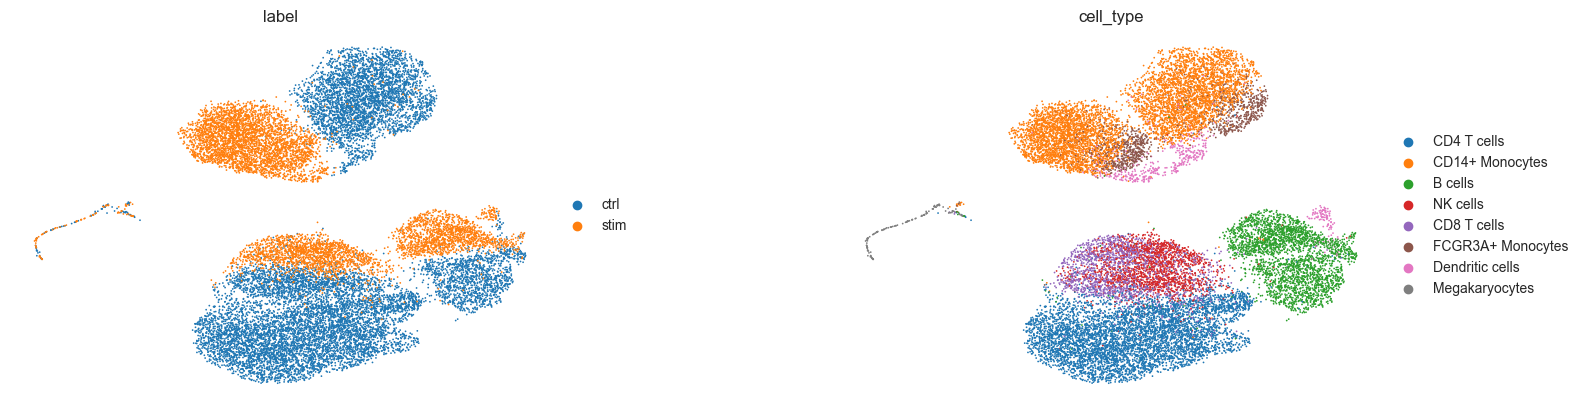

In [10]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(
    latent_adata,
    color=["label", "cell_type"],
    wspace=0.4,
    frameon=False,
    save="latentspace_batch32_klw000005_z100__100e.pdf",
)

## Prediction

After training the model you can pass the adata of the cells you want to perturb. Here we pass unperturbed CD4 T cells


Here the AnnData object contains the cells that you want estimate the perturbation based on them. we set "ctrl" to our control labels and "stim" to our stimulated labels. If you apply it in another context just set "ctrl" :"your_control_label" and "stim":"your_stimulated_label". the returned value is a numpy matrix of our predicted cells and the second one is the difference vector between our conditions which might become useful later.

In [11]:
pred, delta = scgen_model.predict(ctrl_key="ctrl", stim_key="stim", celltype_to_predict="CD4 T cells")
pred.obs["label"] = "pred"

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


## Evaluation of the prediction

#### Extracting both control and real stimulated CD4 T cells from our dataset

In [12]:
ctrl_adata = train[((train.obs["cell_type"] == "CD4 T cells") & (train.obs["label"] == "ctrl"))]
stim_adata = train[((train.obs["cell_type"] == "CD4 T cells") & (train.obs["label"] == "stim"))]

Merging predicted cells with real ones

In [13]:
eval_adata = ctrl_adata.concatenate(stim_adata, pred)

### Embedding all real and predicted cells in one PCA plot

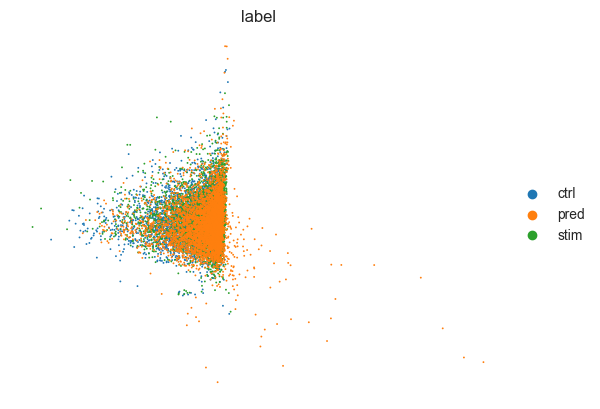

In [14]:
sc.tl.pca(eval_adata)
sc.pl.pca(
    eval_adata,
    color="label",
    frameon=False,
    save="pred_stim_b32_klw000005_z100__100e.pdf",
)

## Mean correlation plot

You can also visualize your mean gene expression of your predicted cells vs control cells while highlighting your genes of interest (here top 10 differentially expressed genes)

In [15]:
CD4T = train[train.obs["cell_type"] == "CD4 T cells"]

In [16]:
sc.tl.rank_genes_groups(CD4T, groupby="label", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["stim"]
print(diff_genes)

['ISG15' 'IFI6' 'ISG20' ... 'EEF1A1' 'FTH1' 'RGCC']


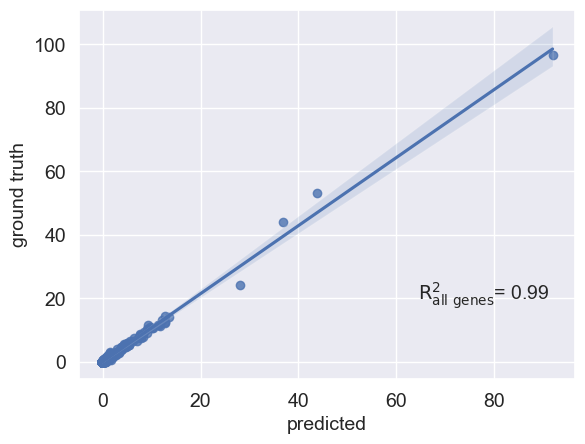

In [17]:
condition_key = scgen_model.adata_manager.get_state_registry(REGISTRY_KEYS.BATCH_KEY).original_key

r2_value = scgen_model.plot_reg_mean_plot(
    eval_adata,
    condition_key=condition_key,
    axis_keys={"x": "pred", "y": "stim"},
    labels={"x": "predicted", "y": "ground truth"},
    path_to_save="./reg_mean.pdf",
    show=True,
    legend=False,
)

You can also pass a list of differentially expressed genes to compute correlation based on them

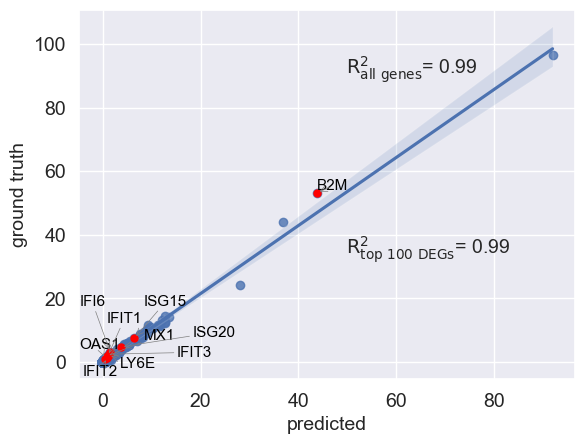

In [18]:
r2_value, r_value_diff = scgen_model.plot_reg_mean_plot(
    eval_adata,
    condition_key=condition_key,
    axis_keys={"x": "pred", "y": "stim"},
    gene_list=diff_genes[:10],
    top_100_genes=diff_genes,
    x_coeff=0.91,
    y_coeff=0.76,
    labels={"x": "predicted", "y": "ground truth"},
    path_to_save="./reg_mean_diff_genes.pdf",
    show=True,
    legend=False,
)

### Violin plot for a specific gene

Let's go deeper and compare the distribution of "ISG15", the top DEG between stimulated and control CD4T cells between predcited and real cells:

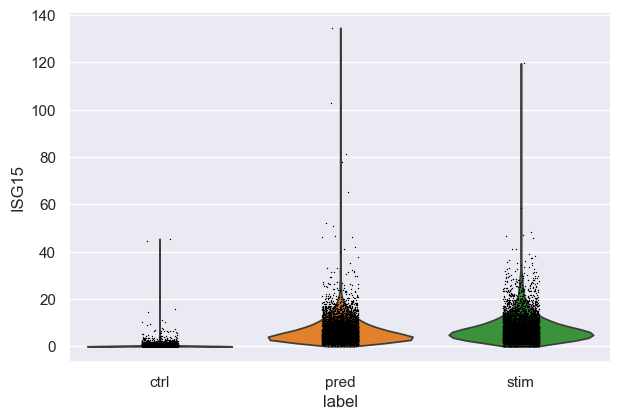

In [19]:
sc.pl.violin(eval_adata, keys="ISG15", groupby="label")